# Jules Dartois, Valentin Bérisset. 'Deep neural network under-sampled image reconstruction for X-Ray tomography.' 

##  Imports

In [2]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import cv2
import fht
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.io as sio
import scipy.linalg as lin
from PIL import Image, ImageOps
from pathlib import Path
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import model_Radon_DCAN as model_radon
import h5py as h5
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

## User-defined parameters

In [8]:
#- Acquisition
img_size = 64 # image size
pixel_size = 64 #Number of pixels of the sensor
nbAngles = 20 #Number of measured angles
user = 0 #Jul or Entin

#- Using CPU or GPU
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')

# 1 - Computed Tomography and Radon operator

## Computed Tomography
Computed tomography or CT indicates the reconstruction 2D and 3D objects from absorption measurments. The idea is to identify the absorption of each point in the object as the absorption can give us an idea of the the local nature of the object. CT is used in Non-Destructive Control operations but most notably in medical imaging, where the absorption helps us identfy the type of organic matter (bone, muscle, etc...). The acquisition step can be modelised by the Radon transform which is, simply put, the continuous version of the Hough transform.

## Radon transform
The Radon transform is a non-linear projection extracting a sinogram from an object. We modelise the object by a discrete object image with a chosen resolution. Rays are projected onto a series of pixels passing through the object and the total absorption is measured. The operation is repeated for a certain number of angles. We are working on a model based on a 2nd generation scanner as represented below:  

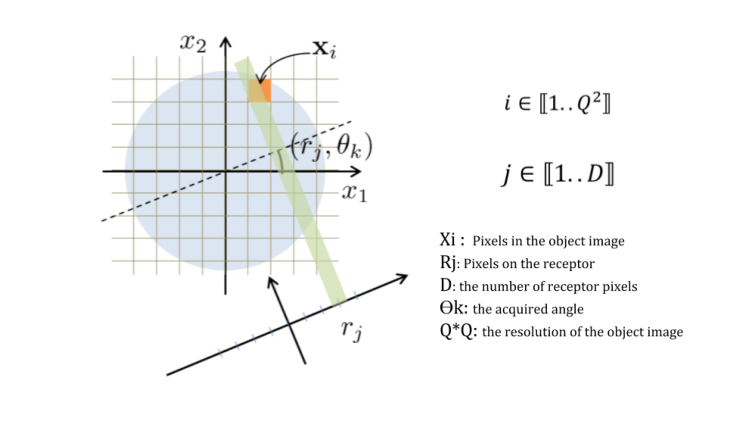

In [21]:
ill =  mpimg.imread("tomo.png")
fig, ax= plt.subplots(figsize=(13,13))
myaximage = ax.imshow(ill)
ax.set_axis_off()
plt.show()

Considering each small section of the scanned object as a pixel of the object image, we can link a pixel to a sinusoid on the sinogram as illustrated here:

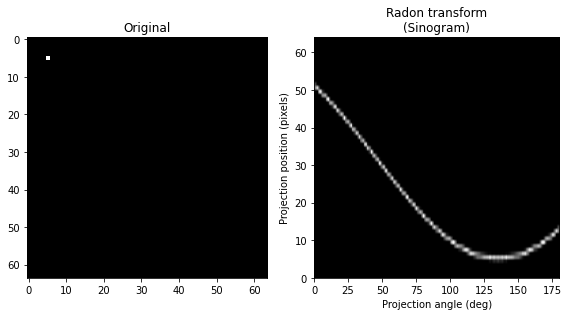

In [9]:
#Vector with acquired angles
theta = torch.linspace(0., 180., 181)

#Creation of an object image with a single activated pixel
example = torch.zeros(img_size,img_size)
example[5,5] = 1

#Simulation of scan via radon function
sinogram = radon(example, theta, circle=False)
sinogram = rescale(sinogram, scale=(pixel_size/sinogram.shape[0],1), mode='reflect', multichannel=False)

#Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))
ax1.set_title("Original")
ax1.imshow(example, cmap=plt.cm.Greys_r)

ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')

fig.tight_layout()
plt.show()

## The radon operator
We wish to include the radon operator in our neural network in order to produce sinograms on which we can train denoising and completion. One way to do this is to transform the radon operator by a matrix multiplication. We will call this matrix A. 
By executing the above operation for each pixel in the object image, we can link each pixel's influence on the sinogram. The juxtapostion of the resulting sinograms creates the A matrix which has the following dimensions:

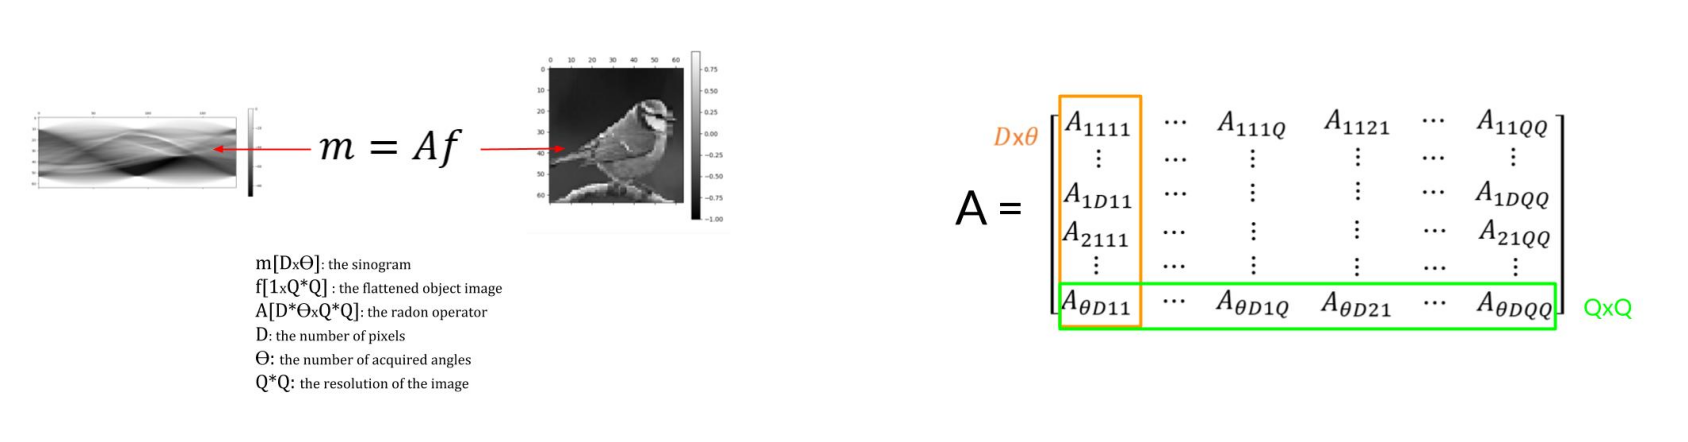

In [41]:
im1 =  mpimg.imread("def var.jpg")
im2 =  mpimg.imread("dim.jpg")
fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(30,30))
ax1.imshow(im1)
ax2.imshow(im2)
ax1.set_axis_off()
ax2.set_axis_off()
plt.show()

### Creating the operator

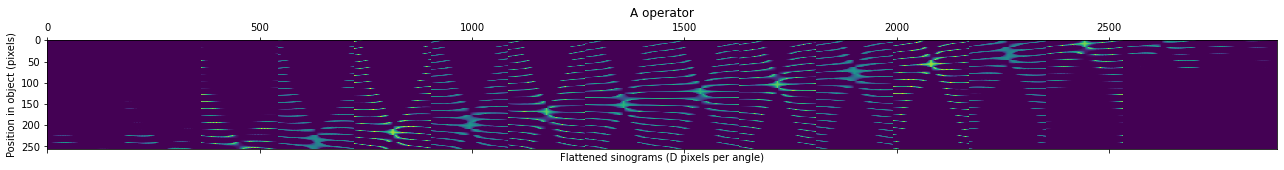

In [22]:
#Define empty A matrix
img_size_example = 16
pixel_size_example = 16
A_example = torch.zeros(pixel_size_example*181, img_size_example*img_size_example)

for i in range(img_size_example):
    for j in range(img_size_example):
        #Activating a single pixel of the object image
        image = torch.zeros(img_size_example,img_size_example)
        image[i,j] = 1
        
        #Radon transform
        sinogram = radon(image, theta, circle=False)
        sinogram = rescale(sinogram, scale=(pixel_size_example/sinogram.shape[0],1), mode='reflect', multichannel=False)
        
        #Juxtaposing results in A matrix
        A_example[:,pixel_size_example*i+j] = torch.flatten(torch.from_numpy(sinogram[:,:])) 

        
#A matrix visualisation
fig, ax = plt.subplots(figsize=(100, 2))
ax.matshow(A_example.t())
ax.set_title("A operator")
ax.set_xlabel("Flattened sinograms (D pixels per angle)")
ax.set_ylabel("Position in object (pixels)")
plt.show()

### Testing the resulting matrix

(16, 181)
torch.Size([16, 181])


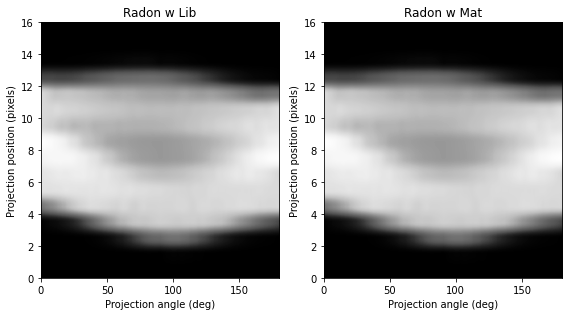

In [43]:
phantom = shepp_logan_phantom()
phantom = rescale(phantom, scale=(img_size_example/phantom.shape[0]), mode='reflect', multichannel=False)

#Radon transform with skimage function
radon1 = radon(phantom, theta, circle=False)
radon1 = rescale(radon1, scale=(pixel_size_example/radon1.shape[0], 1), mode='reflect', multichannel=False)

#Radon transform with A matrix
radon2 = torch.mv(A_example,torch.flatten(torch.tensor(phantom).float()))
radon2 = radon2.view(img_size_example, 181)

#Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))
ax1.set_title("Radon w Lib")
ax1.set_xlabel("Projection angle (deg)")
ax1.set_ylabel("Projection position (pixels)")
ax1.imshow(radon1, cmap=plt.cm.Greys_r, extent=(0, 180, 0, radon1.shape[0]), aspect='auto')

ax2.set_title("Radon w Mat")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(radon2, cmap=plt.cm.Greys_r, extent=(0, 180, 0, radon2.shape[0]), aspect='auto')

fig.tight_layout()
plt.show()

### Inverse matrix

With this modelisation of the problem, an immediate idea is to use the inverse matrix of A in order to reconstruct the image from the sinogram. However, the A operator is not square, meaning it isn't properly inversible. Thus, we will be using the generalised inverse or "pseudo inverse". Furthermore, we will be testing this pseudo inverse method in cases where the sinogram has been acquired with less angles than the A matrix.

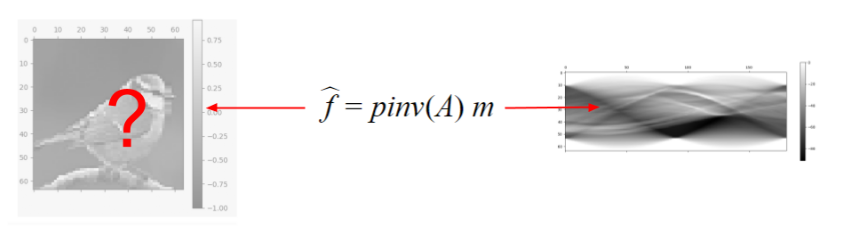

In [26]:
im =  mpimg.imread("ill_pinv.png")
fig, ax= plt.subplots(figsize=(15,15))
myaximage = ax.imshow(im)
ax.set_axis_off()
plt.show()

# 2 - Compressed Acquisition

Now we have the forward matrix A, we can compute the pseudo inverse to solve the backprojection problem. However, in reality, we might not have access to a measurement with a resolution of one angle. In this case, we can reduce the number of measurement angles to see if the image quality stays acceptable.

## Loading forward, retroprojection matrix and compute new matrixes for a reduced number of measurement angles

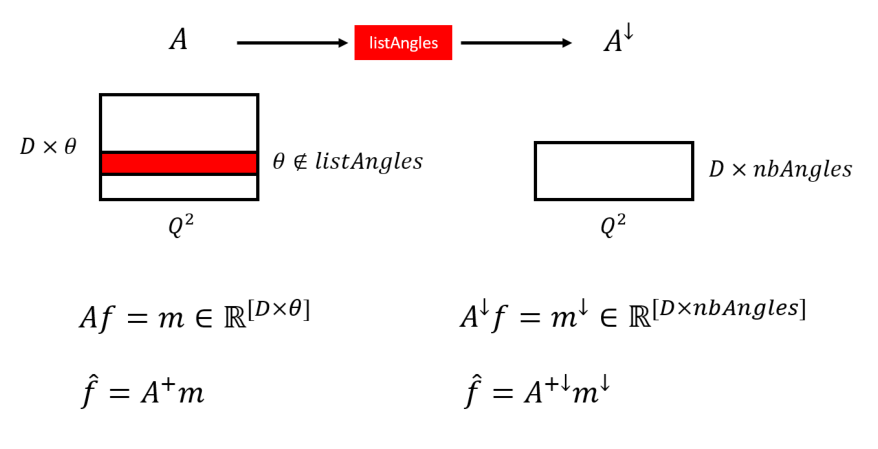

In [15]:
im1 =  mpimg.imread("Explain_a_reduced.PNG")
plt.figure(figsize=(30,8))
plt.imshow(im1)
plt.axis('off')
plt.show()

In [5]:
print('Loading forward matrix')
radon_matrix_path = 'Q{}_D{}.mat'.format(img_size,pixel_size)
if user == 0:
    H = h5.File(radon_matrix_path, 'r')
else: 
    H = sio.loadmat(radon_matrix_path)
A = H.get("A")
A = np.array(A)
if user == 0:
    A = np.transpose(A)
A = torch.from_numpy(A)
A = A.type(torch.FloatTensor)
Areduced = model_radon.radonSpecifyAngles(A, model_radon.generateAngles(nbAngles))
Areduced = Areduced.type(torch.FloatTensor)

radon_matrix_path = 'pinv_Q{}_D{}.mat'.format(img_size,pixel_size)
H = h5.File(radon_matrix_path, 'r')
pinvA = H.get("A_pinv")
pinvA = np.array(pinvA)
pinvA = np.transpose(pinvA)
pinvA = torch.from_numpy(pinvA)
pinvA = pinvA.type(torch.FloatTensor)

print('Computing pseudo inverse of the forward matrix')
if device == "cuda:0":
    pinvAreduced = lin.pinv(Areduced.cpu().numpy())
else:
    pinvAreduced = lin.pinv(Areduced.numpy())
    
pinvAreduced = torch.from_numpy(pinvAreduced)
pinvAreduced = pinvAreduced.type(torch.FloatTensor)
print("Done")

Loading forward matrix
Computing pseudo inverse of the forward matrix
Done


In order to save calculation time, we computed the forward matrix once with 181 angles. Then, to simulate a measurement with fewer angles, we delete some of the matrix's rows and we use a new matrix called A reduced. Finally, we compute the pseudo-inverse of this reduced matrix for making backprojection. 

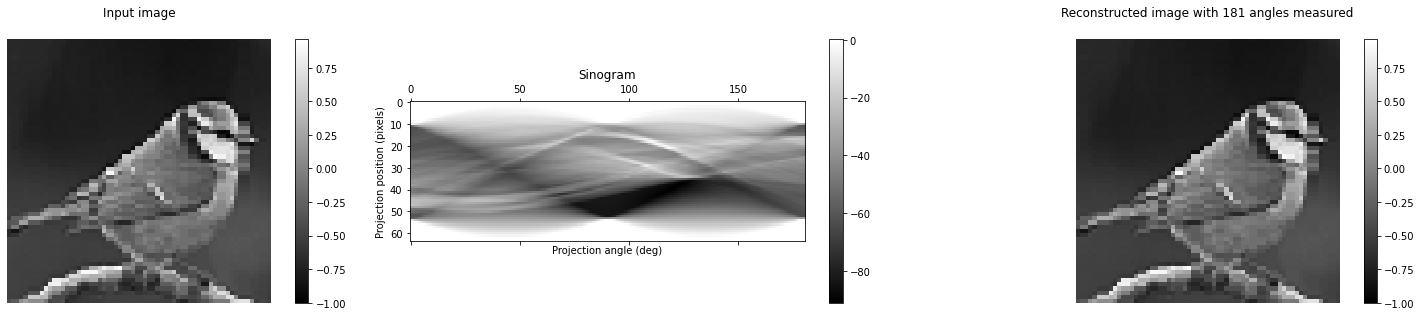

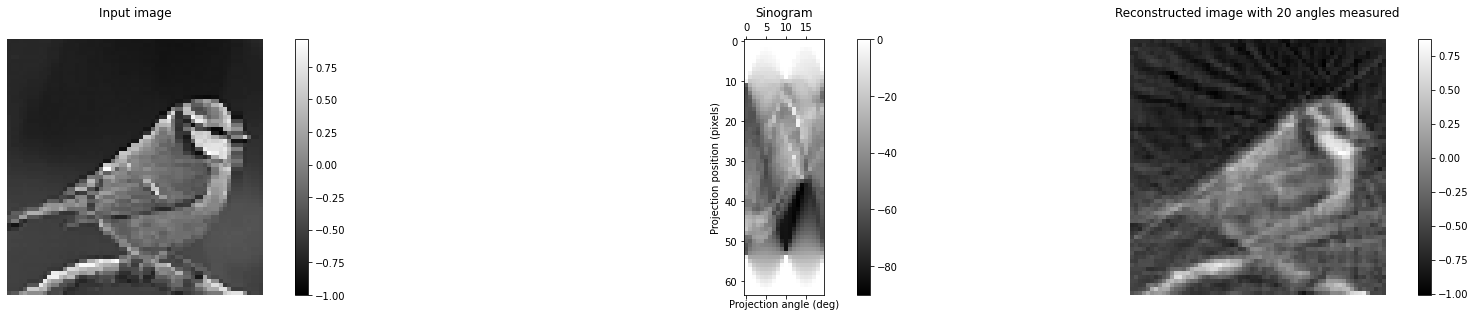

In [6]:
#Importer une image
im = Image.open("image.png")
im = ImageOps.grayscale(im)

phantom = shepp_logan_phantom()
phantom = rescale(phantom, scale=(img_size/400), mode='reflect', multichannel=False)

im_array = np.asarray(im)

im_array = im_array.astype(np.float32)
im_array = 2*(im_array)/255 - np.ones([64,64])
f = torch.from_numpy(im_array)
f = f.view(1,64*64);
f = f.t()
f = f.type(torch.FloatTensor)

#Effectuer une mesure
m = torch.mv(Areduced,f[:,0])
m_perfect = torch.mv(A,f[:,0])

#afficher le sinogrames plein
m_perfect_array = model_radon.vector2matrix(m_perfect, [181,64])

#afficher le sinogrames réduit
m_array = model_radon.vector2matrix(m, [nbAngles,64])

#Reconstruire avec A
f_perfect = torch.mv(pinvA,m_perfect)
f_perfect_array = model_radon.vector2matrix(f_perfect, [64,64])
f_perfect_array = np.transpose(f_perfect_array)

#Reconstruire avec Areduced
f_reconstruct = torch.mv(pinvAreduced,m)
f_reconstruct_array = model_radon.vector2matrix(f_reconstruct, [64,64])
f_reconstruct_array = np.transpose(f_reconstruct_array)

#Affichage
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 4.5))

ax1.set_title("Input image")
pcm1 = ax1.matshow(im_array, cmap='gray')
ax1.set_axis_off()

ax2.set_title("Sinogram")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
pcm2 = ax2.matshow(m_perfect_array, cmap='gray')


ax3.set_title("Reconstructed image with 181 angles measured")
pcm3 = ax3.matshow(f_perfect_array, cmap='gray')
ax3.set_axis_off()

fig.colorbar(pcm1,ax=ax1)
fig.colorbar(pcm2,ax=ax2)
fig.colorbar(pcm3,ax=ax3)
fig.tight_layout()

fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 4.5))

ax1.set_title("Input image")
pcm1 = ax1.matshow(im_array, cmap='gray')
ax1.set_axis_off()

ax2.set_title("Sinogram")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
pcm2 = ax2.matshow(m_array, cmap='gray')

ax3.set_title("Reconstructed image with 20 angles measured")
pcm3 = ax3.matshow(f_reconstruct_array, cmap='gray')
ax3.set_axis_off()

fig2.colorbar(pcm1,ax=ax1)
fig2.colorbar(pcm2,ax=ax2)
fig2.colorbar(pcm3,ax=ax3)
fig2.tight_layout()

plt.show()


These figures show the reconstruction of an input image for two number of angles for acquisition. The first one uses the full 181 angles operator matrix whereas the second one uses only 20 angles. We can observe that when reducing the number of acquisition angles, the quality of the reconstructed image is decreased. How many angles should we measure to have a reasonable reconstruct quality when keeping the number of measurement angles low ?

## Reconstructed images for multiple numbers of acquisition angles

Compute 4 matrixes and pseudo-inverse


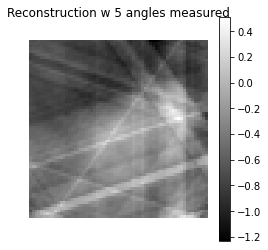

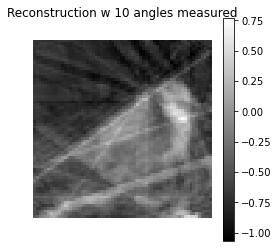

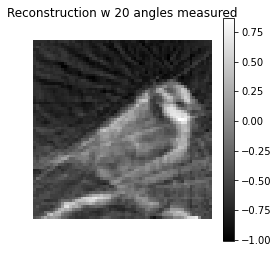

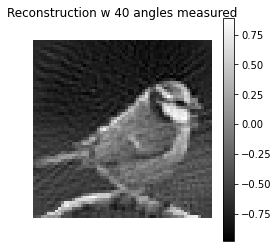

In [7]:
nbReconstruct = 4

listAngles = np.array([5, 10, 20, 40, 60, 80, 100, 140, 180])

print('Compute {} matrixes and pseudo-inverse'.format(nbReconstruct))
for i in range(0,nbReconstruct):
    Areduced = model_radon.radonSpecifyAngles(A, model_radon.generateAngles(listAngles[i]))
    Areduced = Areduced.type(torch.FloatTensor)
    if device == "cuda:0":
        pinvAreduced = lin.pinv(Areduced.cpu().numpy())
    else:
        pinvAreduced = lin.pinv(Areduced.numpy())
    pinvAreduced = torch.from_numpy(pinvAreduced)
    pinvAreduced = pinvAreduced.type(torch.FloatTensor)
    m = torch.mv(Areduced,f[:,0])
    f_reconstruct = torch.mv(pinvAreduced,m)
    f_reconstruct_array = model_radon.vector2matrix(f_reconstruct, [64,64])
    f_reconstruct_array = np.transpose(f_reconstruct_array)
    plt.matshow(f_reconstruct_array, cmap='gray')
    plt.title("Reconstruction w {} angles measured".format(listAngles[i]))
    plt.colorbar()
    plt.axis('off')
    plt.show()

We can observe that when having at least 60 angles, the quality of the reconstructed images is reasonable.

# 3 - Statistical completion

## Problem of pseudo-inverse

Compute new formula of pseudo-inverse


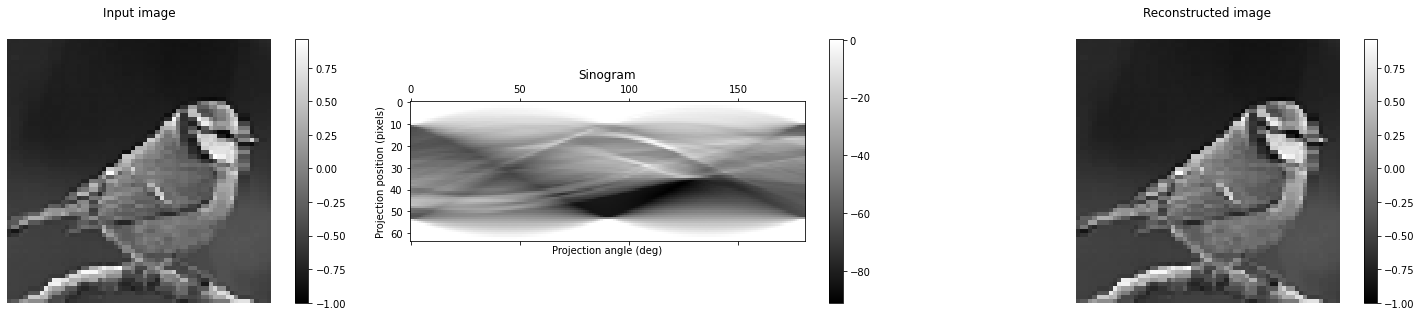

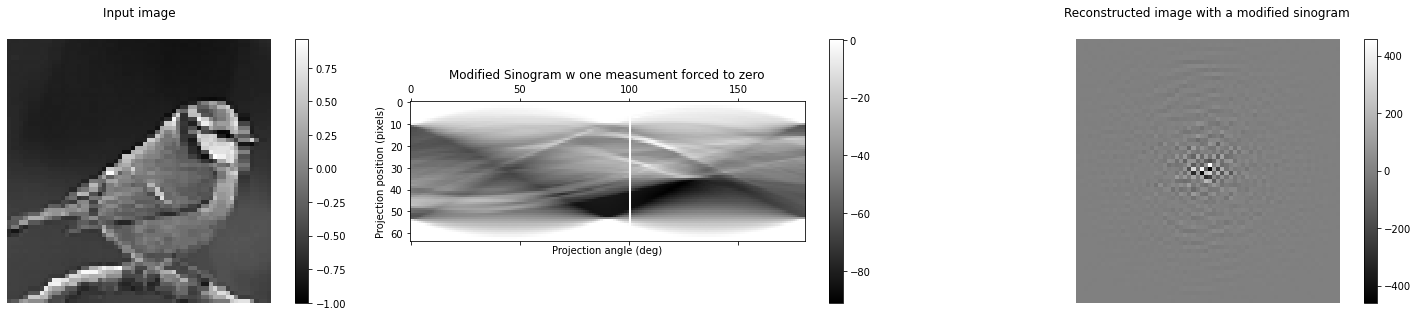

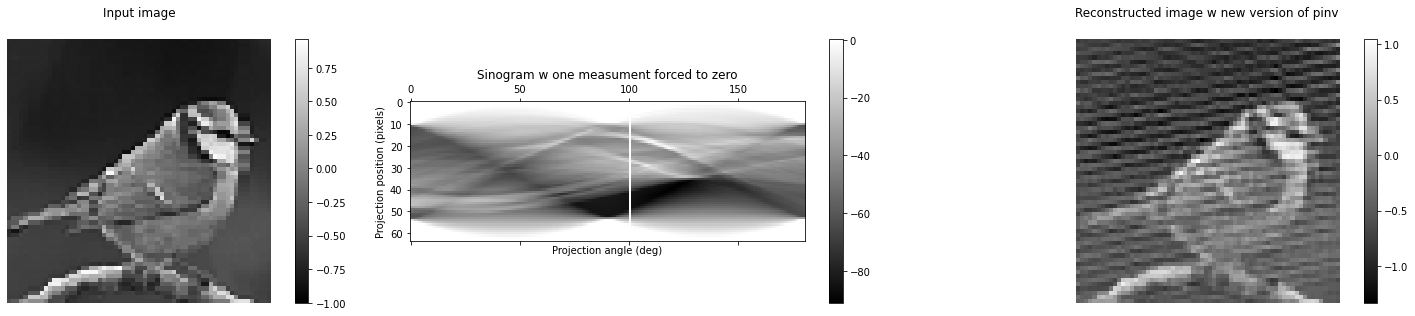

In [7]:
#afficher le sinogrames modifié
m_modified = m_perfect.clone().detach()
m_modified[6400:6464] = 0 

m_modified_array = model_radon.vector2matrix(m_modified, [181,64])

#Reconstruire avec A
f_reconstruct2 = torch.mv(pinvA,m_modified)
f_reconstruct2_array = model_radon.vector2matrix(f_reconstruct2, [64,64])
f_reconstruct2_array = np.transpose(f_reconstruct2_array)

print('Compute new formula of pseudo-inverse')
regu = 1e1
if device == "cuda:0":
    pinvA2 = np.dot(lin.inv(np.dot(np.transpose(A.cpu().numpy()),A.cpu().numpy())+regu*np.eye(64*64)),np.transpose(A.cpu().numpy()))
else:
    pinvA2 = np.dot(lin.inv(np.dot(np.transpose(A.numpy()),A.numpy())+regu*np.eye(64*64)),np.transpose(A.numpy()))
pinvA2 = torch.from_numpy(pinvA2)
pinvA2 = pinvA2.type(torch.FloatTensor)

#Reconstruire avec A avec la nouvelle pinv
f_reconstruct3 = torch.mv(pinvA2,m_modified)
f_reconstruct3_array = model_radon.vector2matrix(f_reconstruct3, [64,64])
f_reconstruct3_array = np.transpose(f_reconstruct3_array)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 4.5))

ax1.set_title("Input image")
pcm1 = ax1.matshow(im_array, cmap='gray')
ax1.set_axis_off()

ax2.set_title("Sinogram")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
pcm2 = ax2.matshow(m_perfect_array, cmap='gray')

ax3.set_title("Reconstructed image")
pcm3 = ax3.matshow(f_perfect_array, cmap='gray')
ax3.set_axis_off()

fig.colorbar(pcm1,ax=ax1)
fig.colorbar(pcm2,ax=ax2)
fig.colorbar(pcm3,ax=ax3)
fig.tight_layout()

fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 4.5))

ax1.set_title("Input image")
pcm1 = ax1.matshow(im_array, cmap='gray')
ax1.set_axis_off()

ax2.set_title("Modified Sinogram w one measument forced to zero")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
pcm2 = ax2.matshow(m_modified_array, cmap='gray')

ax3.set_title("Reconstructed image with a modified sinogram")
pcm3 = ax3.matshow(f_reconstruct2_array, cmap='gray')
ax3.set_axis_off()

fig2.colorbar(pcm1,ax=ax1)
fig2.colorbar(pcm2,ax=ax2)
fig2.colorbar(pcm3,ax=ax3)
fig2.tight_layout()

fig3, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 4.5))

ax1.set_title("Input image")
pcm1 = ax1.matshow(im_array, cmap='gray')
ax1.set_axis_off()

ax2.set_title("Sinogram w one measument forced to zero")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
pcm2 = ax2.matshow(m_modified_array, cmap='gray')

ax3.set_title("Reconstructed image w new version of pinv")
pcm3 = ax3.matshow(f_reconstruct3_array, cmap='gray')
ax3.set_axis_off()

fig3.colorbar(pcm1,ax=ax1)
fig3.colorbar(pcm2,ax=ax2)
fig3.colorbar(pcm3,ax=ax3)
fig3.tight_layout()

plt.show()

We can see on those figures that the backprojection matrix seems to be ill-conditioned for small variations in the sinogram. For example, if we force a column of the sinogram to zero, the reconstructed image ins't good at all. If we see changing pixels values of the sinogram as adding noise to it, an other method of computing the pseudo-inverse matrix could solve this issue introducing a regularisation parameter. 

The next step consist of filling sinogram's missing values using statistical completion and compare the reconstruction with previous method.

## Statistical completion

The idea of statistical completion is to give a value for missing data depending on statistics from a dataset. In the example below taken from [1] we can see that the value of a certain pixel in the image is correlated with the values of other pixels (here between coefficient 7 and 2).

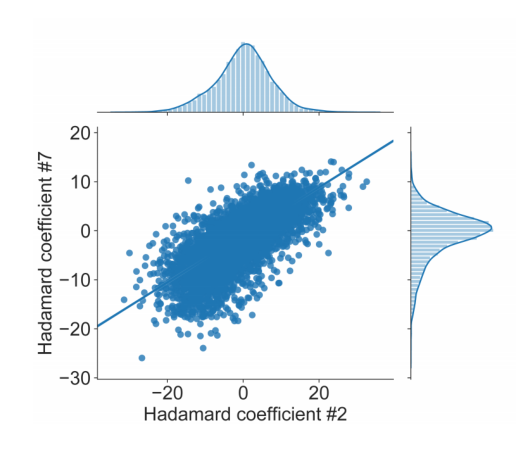

In [9]:
im1 =  mpimg.imread("Hadamard_coeff.PNG")
plt.figure(figsize=(30,8))
plt.imshow(im1)
plt.axis('off')
plt.show()

##  Mean and covariance

Instead of computing a new pseudo-inverse matrix from the reduced forward radon matrix A, we can se the problem as a full sinogram with missing measurement. Statistical completion of those missing data show promising result in [1] We can use the STL-10 image library to determine statistical information in order to improve low angle resolution measurements.

[1] 2020 IEEE 17th International Symposium on Biomedical Imaging (ISBI), Apr 2020, Iowa City, United States. pp.619-623.
⟨10.1109/ISBI45749.2020.9098390⟩
[hal-02342766v2](https://hal.archives-ouvertes.fr/hal-02342766v2/document)


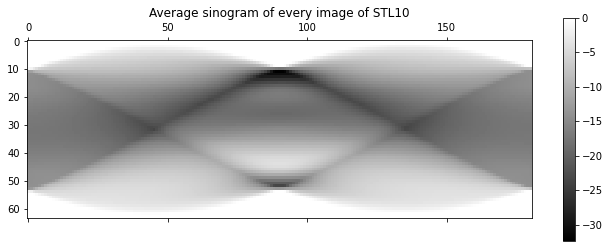

In [8]:
#Import mean and covariance matrix
Mean_radon = torch.load('Mean_Q64D64.pt', map_location='cpu')
Cov_radon = torch.load('Cov_Q64D64.pt', map_location='cpu')

Mean_radon_array = model_radon.vector2matrix(Mean_radon, [181,64])

plt.matshow(Mean_radon_array, cmap='gray')
plt.title("Average sinogram of every image of STL10")
plt.colorbar()
plt.show()

## Statistical completion for consecutive measurement angles

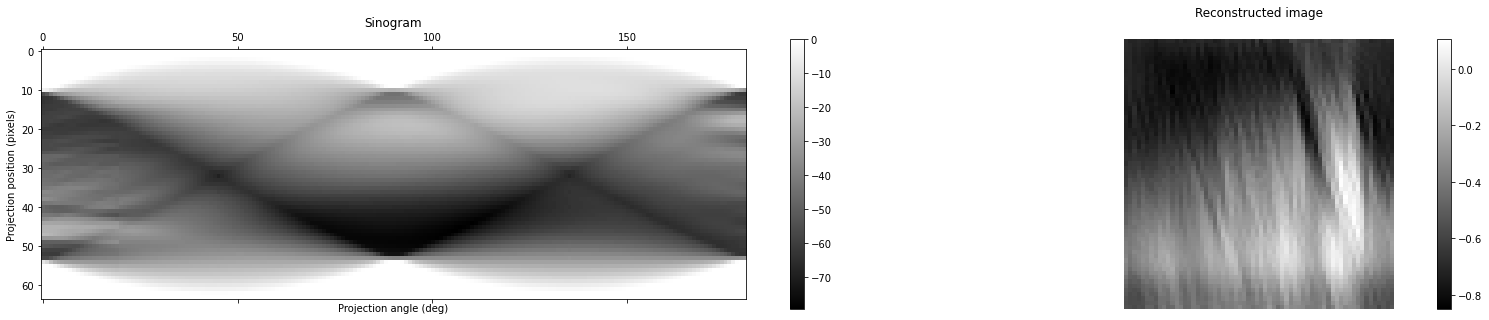

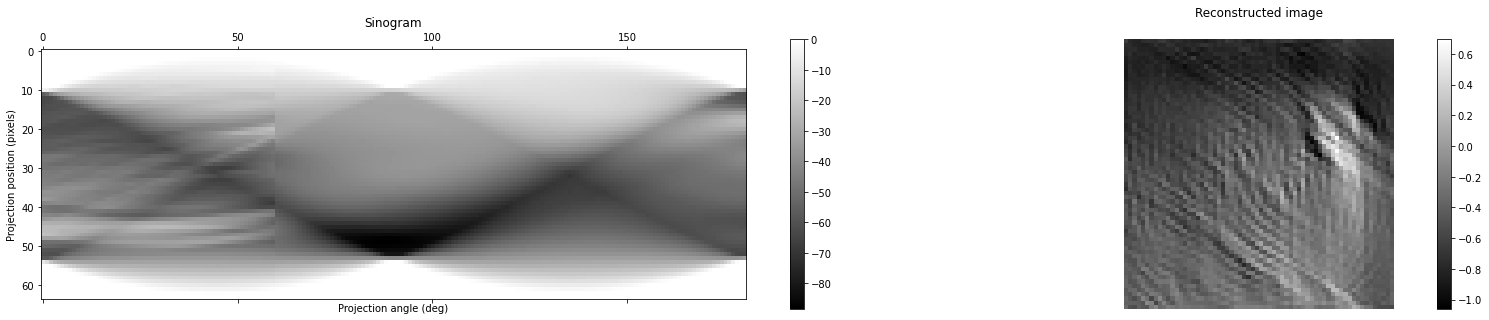

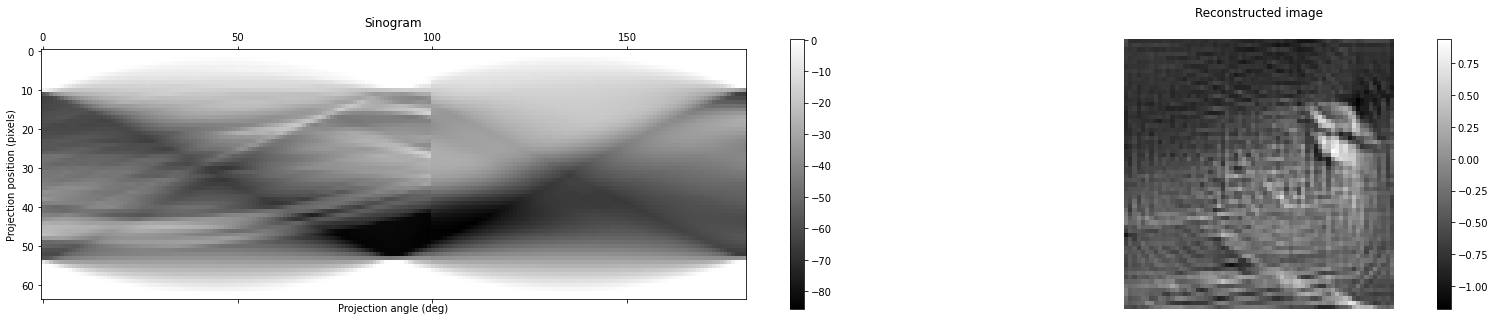

In [53]:
nbReconstruct = 3
listAngles = np.array([20, 60, 100, 150])

for i in range(0,nbReconstruct):
   
    #Tronquer le sinogramme après un certain nombre d'angles d'acquisition
    m_reduced = m_perfect[:listAngles[i]*64]

    #Séparation des moyennes des pixels. mu1 étant l'acquisition et mu2 les pixel à boucher
    mu1 = Mean_radon[:listAngles[i]*64,0]
    mu2 = Mean_radon[listAngles[i]*64:,0]

    #Séparation des covariances des pixels. Simga1 covariance de l'acquisition, Sigma21 la covariance des pixels acquis et non acquis
    Sigma1 = Cov_radon[:64*listAngles[i],:64*listAngles[i]]
    Sigma21 = Cov_radon[64*listAngles[i]:,:64*listAngles[i]]

    #Complétion statistique
    diff = m_reduced-mu1

    sigma1_np = Sigma1.numpy()

    pinvs = lin.pinv(sigma1_np)

    pinvSigma1 = torch.from_numpy(pinvs)

    sMix = torch.matmul(Sigma21,pinvSigma1)

    y2 = mu2 + torch.mv(torch.matmul(Sigma21,pinvSigma1),diff)

    B = torch.mv(sMix,m_reduced)
    B_np = B.numpy()
    W = mu2 - torch.mv(sMix,mu1)
    W_np = W.numpy()
    
    m_complete = torch.zeros(64*181)
    m_complete[:64*listAngles[i]] = m_reduced
    m_complete[64*listAngles[i]:] = y2

    m_complete_array = model_radon.vector2matrix(m_complete, [181,64])    

    f_filled = torch.mv(pinvA2,m_complete)

    f_filled_array = model_radon.vector2matrix(f_filled, [64,64])
    f_filled_array = np.transpose(f_filled_array)    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 4.5))

    ax1.set_title("Sinogram")
    ax1.set_xlabel("Projection angle (deg)")
    ax1.set_ylabel("Projection position (pixels)")
    pcm1 = ax1.matshow(m_complete_array, cmap='gray')

    ax2.set_title("Reconstructed image")
    pcm2 = ax2.matshow(f_filled_array, cmap='gray')
    ax2.set_axis_off()
    
    fig.colorbar(pcm1,ax=ax1)
    fig.colorbar(pcm2,ax=ax2)
    fig.tight_layout()
    plt.show()

The simplest statistical completion algorithm separate the acquired and not acquired data with a treshold. We can observe that the completed sinogram looks great. Nevertheless the reconstruction is not ideal because most of the measurements are with acquisition angles which are close to each other. A smarter idea would be to complete multiple holes in the sinogram while spacing acquisition angles.

## Statistical completion for linear spaced measurement angles

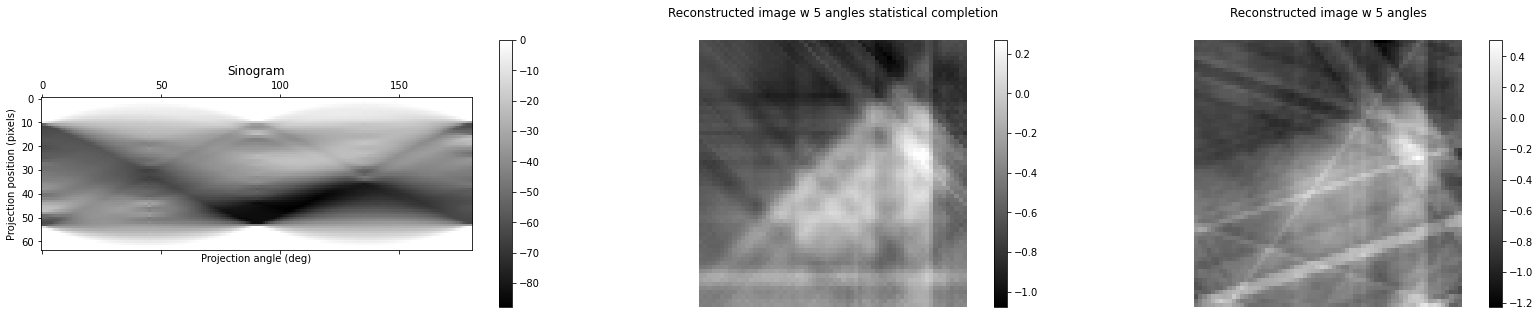

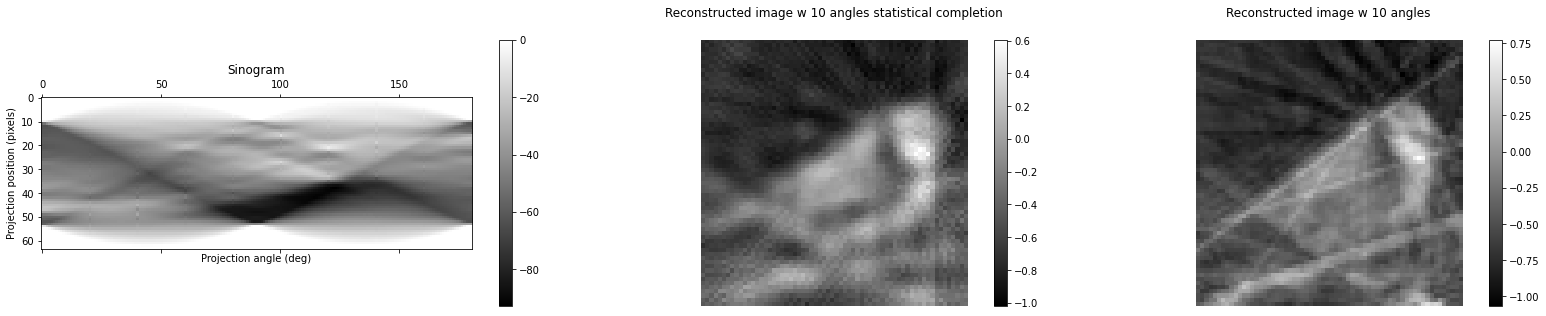

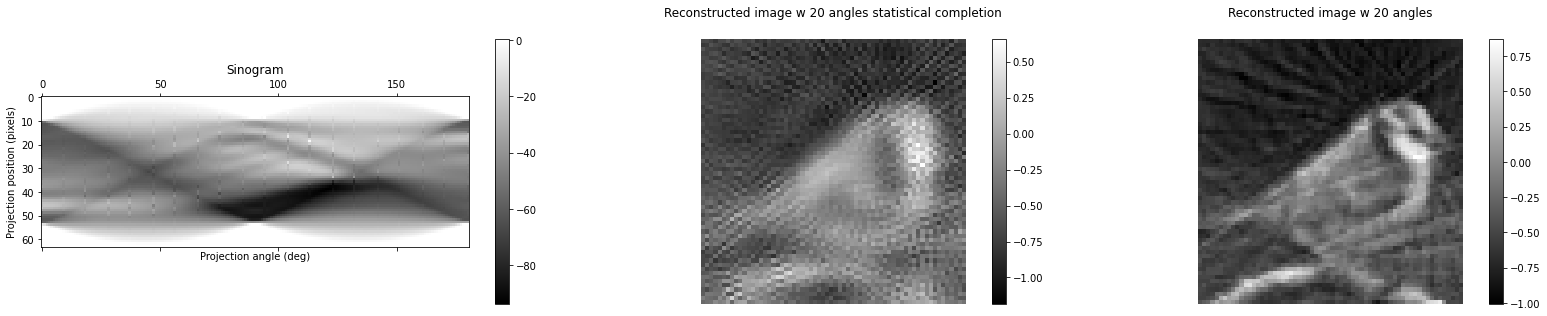

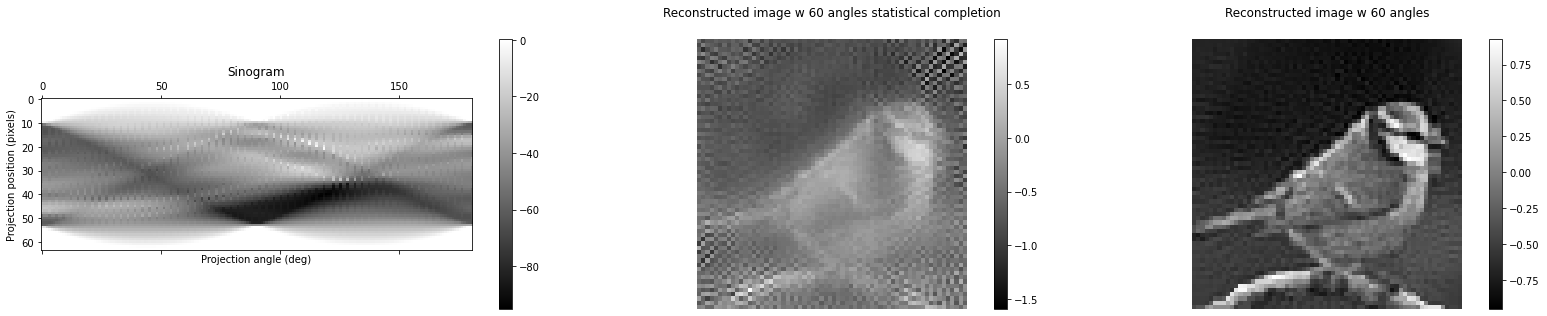

In [12]:
nbReconstruct = 4
listAngles = np.array([5, 10, 20, 60])

mu = Mean_radon.numpy()
sigma = Cov_radon.numpy()

for i in range(0,nbReconstruct):
    
    #Create holes
    angles = model_radon.generateActivationAngles(listAngles[i])
    m_perfect_holes = torch.zeros(listAngles[i]*64)
    m_unperfect = torch.zeros(181*64)
    count = 0
    for j in range(0,181):
        if (angles[j] == 1):
            m_perfect_holes[count*64:count*64+64] = m_perfect[j*64:j*64+64]
            m_unperfect[j * 64:j * 64 + 64] =m_perfect[j*64:j*64+64]
            count = count + 1   
            
    #Statistical completion
    muTuple = model_radon.separateMu(mu,angles,listAngles[i])
    sigmaTuple = model_radon.separateSigma(sigma,angles,listAngles[i])
    networkTuple = model_radon.computeUnknownData(muTuple[0], muTuple[1], sigmaTuple[0], sigmaTuple[1],angles,listAngles[i])

    W = torch.from_numpy(networkTuple[0])
    W = W.type(torch.FloatTensor)
    B = torch.from_numpy(networkTuple[1])
    B = B.type(torch.FloatTensor)

    m_filled_bias = torch.mv(W,m_perfect_holes) + B

    #afficher le sinogrames bouché avec Biais
    m_filled_bias_array = model_radon.vector2matrix(m_filled_bias, [181,64])

    #reconstruire l'image
    f_reconstructed = torch.mv(pinvA2,m_filled_bias)
    f_reconstructed_array = model_radon.vector2matrix(f_reconstructed, [64,64])
    f_reconstructed_array = np.transpose(f_reconstructed_array)

    Areduced = model_radon.radonSpecifyAngles(A, model_radon.generateAngles(listAngles[i]))
    Areduced = Areduced.type(torch.FloatTensor)
    if device == "cuda:0":
        pinvAreduced = lin.pinv(Areduced.cpu().numpy())
    else:
        pinvAreduced = lin.pinv(Areduced.numpy())
    pinvAreduced = torch.from_numpy(pinvAreduced)
    pinvAreduced = pinvAreduced.type(torch.FloatTensor)
    f_poor = torch.mv(pinvAreduced,torch.mv(Areduced,f[:,0]))
    f_poor_array = model_radon.vector2matrix(f_poor, [64,64])
    f_poor_array = np.transpose(f_poor_array)    

    #Afficher les résultats
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 4.5))

    ax1.set_title("Sinogram")
    ax1.set_xlabel("Projection angle (deg)")
    ax1.set_ylabel("Projection position (pixels)")
    pcm1 = ax1.matshow(m_filled_bias_array, cmap='gray')

    ax2.set_title("Reconstructed image w {} angles statistical completion".format(listAngles[i]))
    pcm2 = ax2.matshow(f_reconstructed_array, cmap='gray')
    ax2.set_axis_off()

    ax3.set_title("Reconstructed image w {} angles".format(listAngles[i]))
    pcm3 = ax3.matshow(f_poor_array, cmap='gray')
    ax3.set_axis_off()    
    
    fig.colorbar(pcm1,ax=ax1)
    fig.colorbar(pcm2,ax=ax2)
    fig.colorbar(pcm3,ax=ax3)
    fig.tight_layout()
    plt.show()
    
    plt.show()

Unfortunately, we can observe a sort of noise apearing with the increase in number of measured angles. This might come from the value of the regularisation parameter for the pseudo inverse used for reconstruction with statistical completion.

# 4 - Testing a trained model

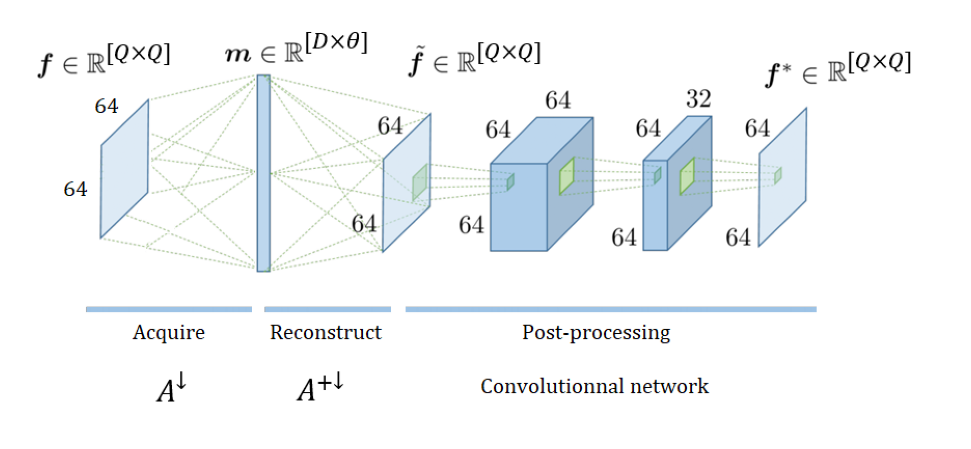

In [56]:
im1 =  mpimg.imread("network.PNG")
plt.figure(figsize=(30,8))
plt.imshow(im1)
plt.axis('off')
plt.show()

In [60]:
#Creating identifying variables
net_types = ['c0mp', 'comp','pinv', 'free']
net_arch = 2
num_epoch = 100
list_angles = np.array([20, 40, 60])
learning_rate = 1e-3
step_size = 10
gamma = 0.5
batch_size = 1000
regularisation = 1e-7

### Testing models trained with different angles

Acquisition of 20 angles
Measurement to image domain: pseudo inverse


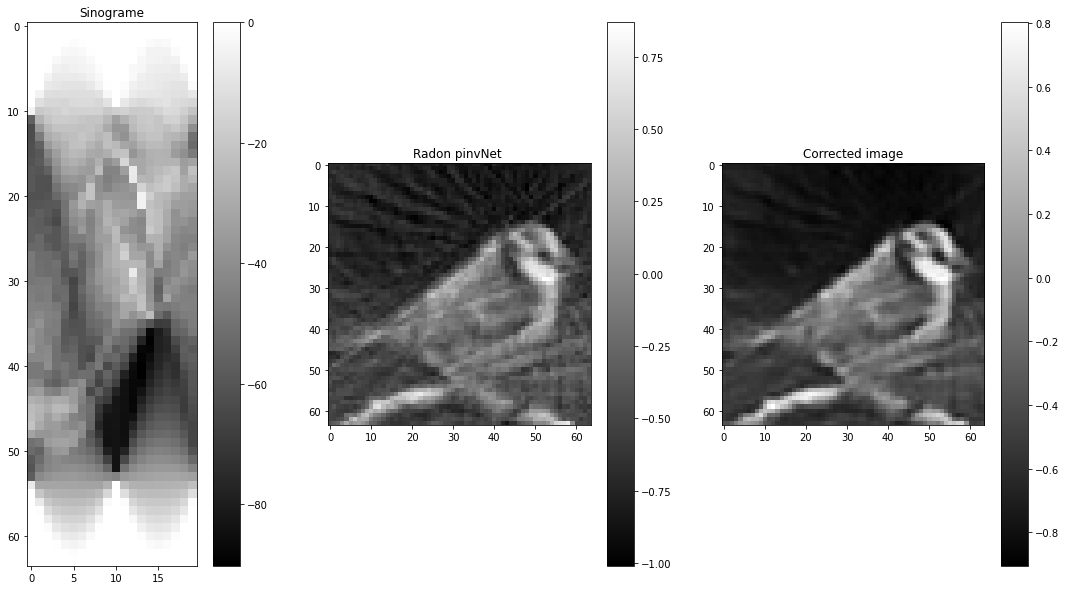

Acquisition of 40 angles
Measurement to image domain: pseudo inverse


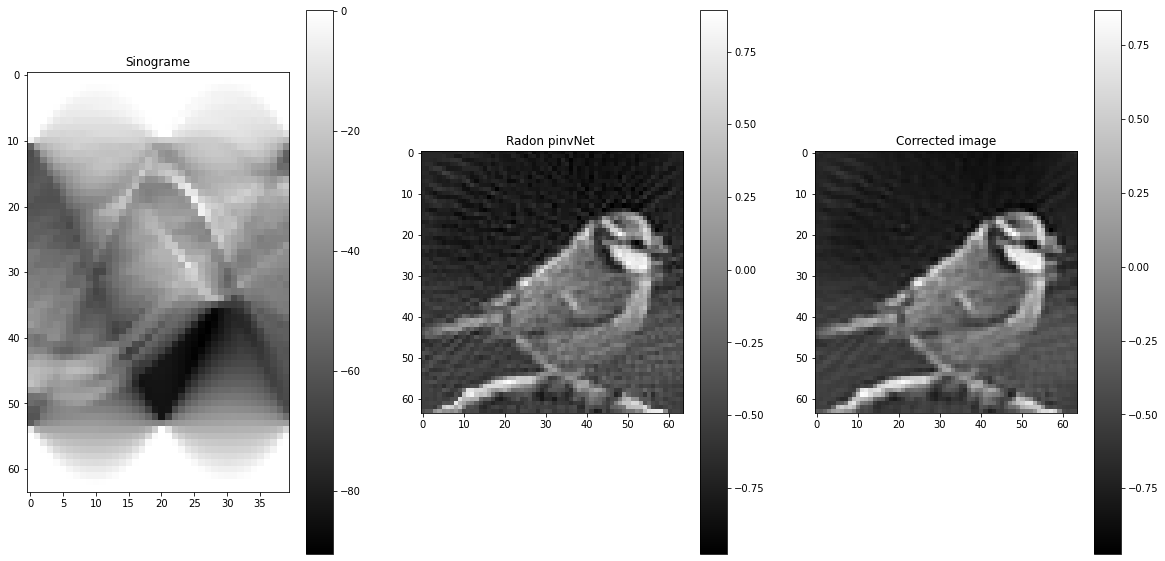

Acquisition of 60 angles
Measurement to image domain: pseudo inverse


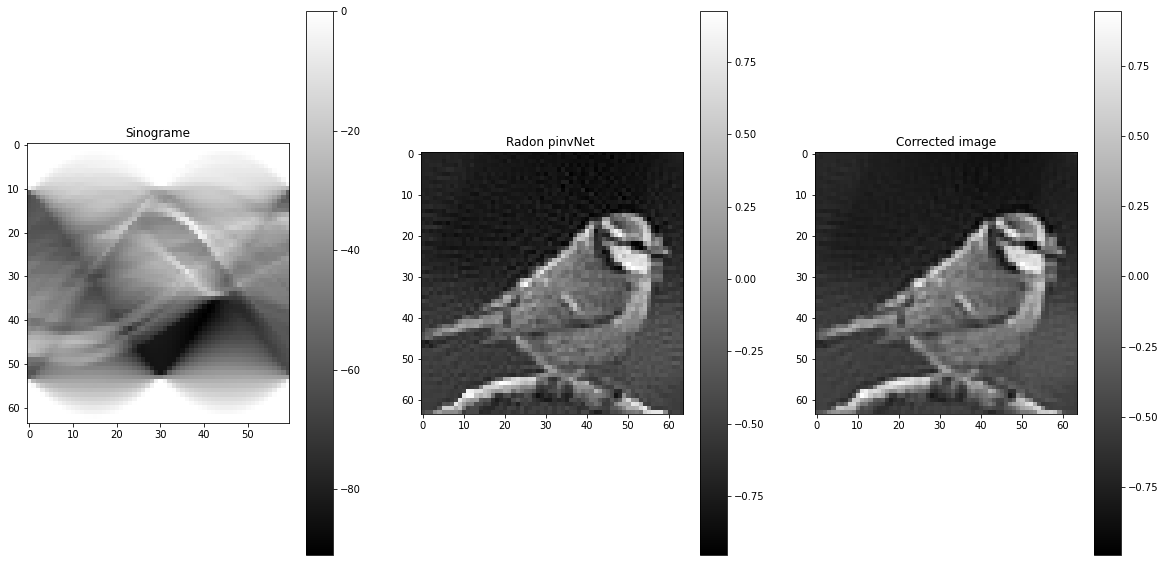

In [58]:
data_root = '../../spyrit/data'

transform = transforms.Compose(
    [transforms.functional.to_grayscale,
     transforms.Resize((img_size, img_size)),
     transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

trainset = \
    torchvision.datasets.STL10(root=data_root, split='train+unlabeled',download=False, transform=transform)
trainloader = \
    torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=False)

testset = \
    torchvision.datasets.STL10(root=data_root, split='test',download=False, transform=transform)
testloader = \
    torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)

dataloaders = {'train': trainloader, 'val': testloader}
inputs, labels = next(iter(dataloaders['val']))
inputs = inputs.to(device)

im_tensor = torch.from_numpy(im_array)
m = torch.mv(Areduced,f[:,0])
test_batch = 1
color = 0
inputs[0, 0, :, :] = im_tensor

for index in range(list_angles.size):
    print("Acquisition of " + list_angles[index].astype(str) + " angles")
    #Deducing model file name
    suffix = '_Q_{}_D_{}_T_{}_epo_{}_lr_{}_sss_{}_sdr_{}_bs_{}_reg_{}'.format(\
                   img_size, pixel_size, list_angles[index], num_epoch, learning_rate, step_size,\
                   gamma, batch_size, regularisation)
    title = 'nets/NET_'+ net_types[net_arch] + suffix

    #loading model
    model = model_radon.compNet(img_size, pixel_size, list_angles[index], variant=net_arch)
    model = model.to(device)
    model_out_path = "{}.pth".format(title)
    model.load_state_dict(torch.load(model_out_path, map_location=torch.device('cpu')))    
    
    #Plots
    fig, axs = plt.subplots(1, 3, figsize =(20,10))
    fig.suptitle('', fontsize=16)
    
    ax = axs[0]
    ax.set_title("Sinograme")
    rec = model.forward_acquire(inputs, test_batch, color, img_size, img_size)
    rec_array = model_radon.vector2matrix(rec[0, :, 0, 0], [list_angles[index], 64])
    aff = ax.imshow(rec_array, cmap='gray')
    fig.colorbar(aff, ax=ax)

    ax = axs[1]
    ax.set_title("Radon pinvNet ")
    rec = model.evaluate_fcl(inputs)
    aff = ax.imshow(rec[0, 0, :, :], cmap='gray')
    fig.colorbar(aff, ax=ax)

    ax = axs[2]
    ax.set_title("Corrected image")
    rec = model.evaluate(inputs)
    aff = ax.imshow(rec[0, 0, :, :], cmap='gray')
    fig.colorbar(aff, ax=ax)
    plt.show()

We can clearly see an improvment with the increasing amount of angles. Additionnaly, the outputs of the neural network present less artefacts than the results of the pseudo-inv multiplication. We will now test a single model with different images from the STL10 library. 

### Testing a model with STL10 images

Measurement to image domain: pseudo inverse


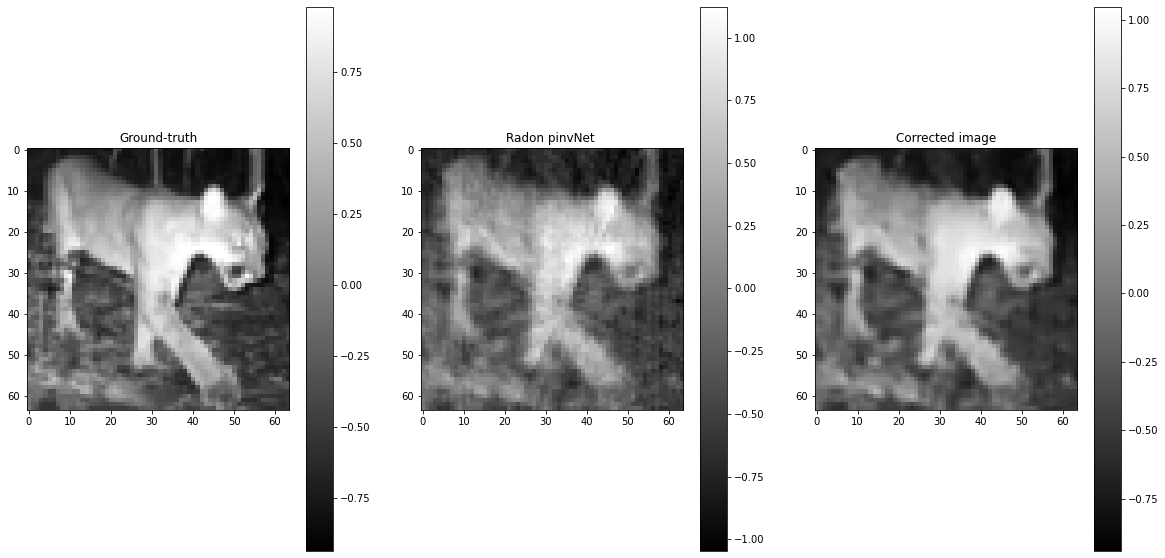

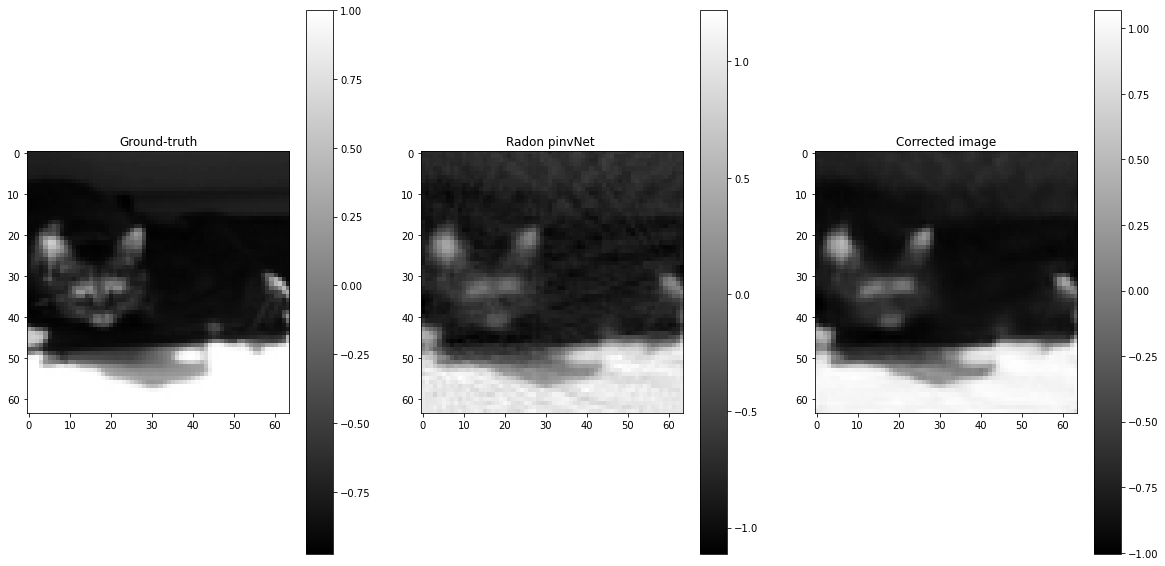

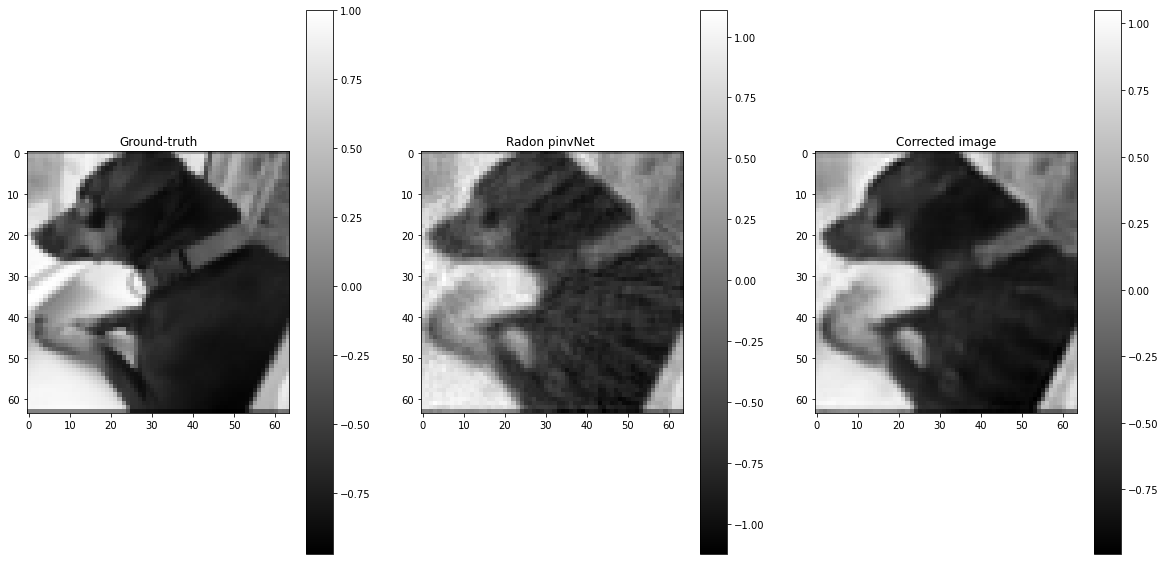

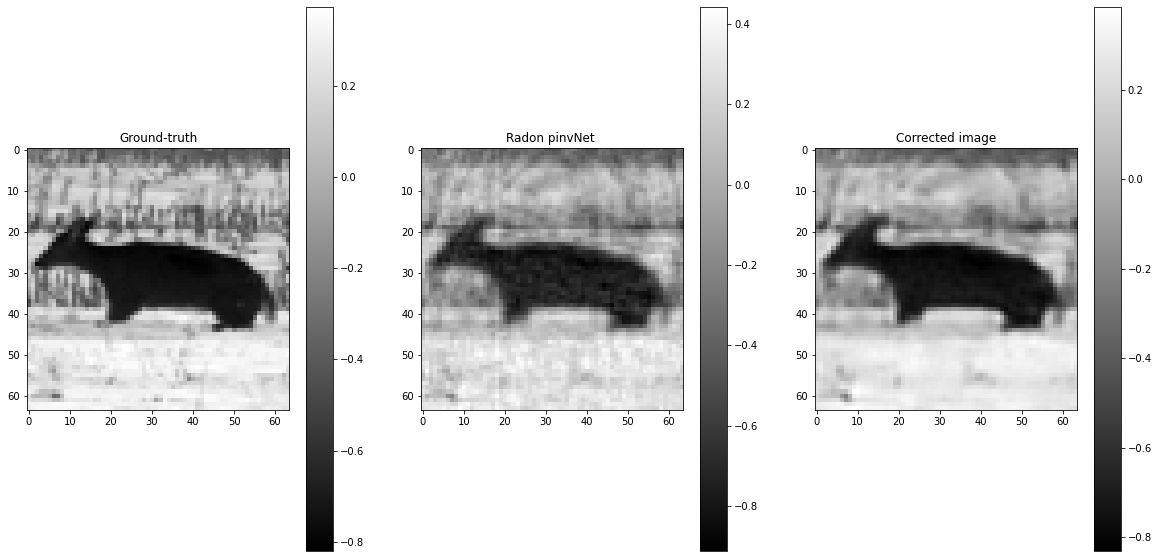

In [62]:
test_amt = 4
nbAngles = 20
inputs, labels = next(iter(dataloaders['val']))
inputs = inputs.to(device)

#Deducing model file name
suffix = '_Q_{}_D_{}_T_{}_epo_{}_lr_{}_sss_{}_sdr_{}_bs_{}_reg_{}'.format(\
               img_size, pixel_size, nbAngles, num_epoch, learning_rate, step_size,\
               gamma, batch_size, regularisation)
title = 'nets/NET_'+ net_types[net_arch] + suffix

#loading model
model = model_radon.compNet(img_size, pixel_size, nbAngles, variant=net_arch)
model = model.to(device)
model_out_path = "{}.pth".format(title)
model.load_state_dict(torch.load(model_out_path, map_location=torch.device('cpu')))    
    

for index in range(test_amt):
    #Choosing random image in STL10
    i_test = np.random.randint(0, inputs.shape[0])
    
    #Plots
    fig, axs = plt.subplots(1, 3, figsize =(20,10))
    fig.suptitle('', fontsize=16)
    
    ax = axs[0]
    ax.set_title("Ground-truth")
    aff = ax.imshow(inputs[i_test, 0, :, :], cmap='gray')
    fig.colorbar(aff, ax=ax)

    ax = axs[1]
    ax.set_title("Radon pinvNet ")
    rec = model.evaluate_fcl(inputs)
    aff = ax.imshow(rec[i_test, 0, :, :], cmap='gray')
    fig.colorbar(aff, ax=ax)

    ax = axs[2]
    ax.set_title("Corrected image")
    rec = model.evaluate(inputs)
    aff = ax.imshow(rec[i_test, 0, :, :], cmap='gray')
    fig.colorbar(aff, ax=ax)
    plt.show()

# Conclusions

This study of the radon transform and 